In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import h5py

`example_utils.py` contain a few helper functions that have been extracted to avoid clutter.

In [2]:
import example_utils as ex

## Introduction

This notebook is a tutorial which describes how to use [Kontiki](https://hovren.github.io/kontiki/) to perform visual-inertial structure from motion on a handheld video sequence, recorded with a GoPro Hero 3+ Black.

<font color="red">**Disclaimer:**</font>
This is a tutorial and therefore it aims for simplicity, and not the best possible results.
You should therefore not expect this pipeline to be state-of-the-art in accuracy or efficiency.
If you find something that can be improved, without making the tutorial more complex, patches are most welcome!

## The data

The dataset provided in `simplified.h5` is generated from the "barn3" sequence in the [GoPro-IMU dataset](http://www.cvl.isy.liu.se/research/datasets/gopro-imu-dataset/).
From the video we have extracted a number of *tracks*, which each contains the pixel location of a tracked point over a number of video frames.
The simplified dataset also contains IMU-measurements which have been preprocessed to be synchronized with the video timestamps (assuming the first frame starts on $t=0$), and had their biases removed.

First we load the camera model from file.

In [3]:
import kontiki.io
camera = kontiki.io.load_atan_camera('gopro-hero3.h5')

The data is then loaded from the `simplified.h5` HDF5 file.
Each track is converted to a `Landmark`, which has a number of `Observation`s.
Each `Observation` also belongs to a `View`, which represents one frame of the video.
Apart from the frame number, there is also the `View.t0` property that defines the start-of-frame time of this particular view/frame. That is, the first and the last row of each image frame were captured on `v.t0`, and `v.t0 + camera.readout`, respectively.

The camera and IMU are using different coordinate frames, and the dataset contains their known relative pose.
Each sensor instance (IMU or camera) has a `.relative_pose` property which defines the trajectory-to-sensor coordinate transformation.
In this case the IMU and trajectory coordinate frames are the same, which means that `camera.relative_pose` is the same as the IMU-to-camera transformation.

In [4]:
from kontiki.sfm import View, Landmark

landmarks = []
landmark_color = {}  # Landmark -> RGB color
_view_map = {}  # Frame number -> View
with h5py.File('simplified.h5', 'r') as f:
    # Load IMU data
    imu_t = f['imu_t'].value
    imu_acc = f['imu_acc'].value
    imu_gyro = f['imu_gyro'].value
    
    # Set relative pose for camera
    p = f['relative_pose/translation'].value
    q = f['relative_pose/orientation'].value
    camera.relative_pose = (q, p)
    
    # Load camera frame rate
    camera_fps = f['camera_fps'].value
    
    for g in f['tracks'].values():
        # Create new landmark
        lm = Landmark()
        
        # Store the landmark, and its color
        landmarks.append(lm)
        landmark_color[lm] = g['color'].value
        
        # Create Views and Observations from tracks
        start = g['start'].value  # Starting frame
        for frame_number, image_point in enumerate(g['points'].value, start=start):
            # Create and store a new View if one doesn't already exist
            t0 = frame_number / camera_fps
            v = _view_map.setdefault(frame_number, View(frame_number, t0))
            
            # Create an observation
            v.create_observation(lm, image_point)

views = sorted(list(_view_map.values()), key=lambda v: v.frame_nr)

print(f'Loaded {len(views)} views with {sum(len(v) for v in views)} observations from {len(landmarks)} landmarks')

Loaded 1185 views with 490673 observations from 15684 landmarks


A `Landmark` is defined not by its 3D coordinate, but by the inverse depth relative to a *reference observation*.
To use the landmarks we therefore let the first observation be the reference, and set the inverse depth to zero.
An inverse depth of zero is equivalent to initially placing the landmark at infinity.

In [5]:
for lm in landmarks:
    lm.inverse_depth = 0
    lm.reference = lm.observations[0]

## Run the SfM pipeline

The SfM pipeline is going to be very simple, just to show how Kontiki works.
Its steps are

1. Use Spline Error Weighting to find a suitable knot spacing for a `SplitTrajectory`. Then compute the appropriate IMU measurement weights.
1. Find a set of *keyframes*, to reduce the computational complexity
1. Choose tracks/landmarks such that each frame has (at least) $k$ observations.
1. Estimate the trajectory from IMU data, and the initial set of image observations.
1. Remove outliers, and find a new set of image measurements, by only keeping landmarks with a mean reprojection error $e < 8$ px.
1. Run the estimator on the new set of measurements.
1. Finally add all observations (all views) for the landmarks with $e < 3$ px.

### Setup trajectory

We are going to use a trajectory which is represented by a set of splines.
For the trajectory and structure estimation to succeed, the splines need to have an appropriate density, and the measurements need to be properly weighted with respect to the approximation error induced by an imperfect spline.

We use a method called Spline Error Weighting (SEW) to find a knot spacing and expected approximation error variance for each of the two sensors, and splines.
We use quality values
$$
q_\text{accelerometer} = 0.97 \text{ and }\\
q_\text{gyroscope} = 0.99 \\
$$
as described in section 2.3 in 

> Hannes Ovrén and Per-Erik Forssén, *Spline Error Weighting for Robust Visual-Inertial Fusion*, In Proceedings of the IEEE on Computer Vision and Pattern Recognition (CVPR), June 2018

In [6]:
from kontiki.sew import knot_spacing_and_variance

min_dt = 0.02  # Don't go lower than this
q_gyro = 0.99
q_acc = 0.97
verbose=False

sew_opts = dict(min_dt=min_dt, verbose=verbose)
so3_dt, so3_var = knot_spacing_and_variance(imu_gyro, imu_t, q_gyro, **sew_opts)
r3_dt, r3_var = knot_spacing_and_variance(imu_acc, imu_t, q_acc, **sew_opts)

gyro_weight = 1 / np.sqrt(so3_var)
acc_weight = 1 / np.sqrt(r3_var)
print(f'SO(3): knot spacing {1000 * so3_dt:.1f} ms ({1/so3_dt:.1f} Hz), gyroscope weight {gyro_weight:.2f}')
print(f'   R3: knot spacing {1000 * r3_dt:.1f} ms ({1/r3_dt:.1f} Hz), accelerometer weight {acc_weight:.2f}')

SO(3): knot spacing 33.2 ms (30.1 Hz), gyroscope weight 26.53
   R3: knot spacing 45.7 ms (21.9 Hz), accelerometer weight 3.11


Now create a trajectory that is valid for all views, using the knot spacing found in the previous step.
The trajectory is now constant with position $p(t) = (0,0,0)$ and orientation $R(t) = \mathbb{I}$.

In [7]:
from kontiki.trajectories import SplitTrajectory

max_time = views[-1].t0 + camera.readout + 1e-2  # Add some margin at the end

t0 = -1e-2  # Margin in beginning of trajectory
trajectory = SplitTrajectory(r3_dt, so3_dt, t0, t0)
trajectory.R3_spline.extend_to(max_time, np.zeros(3))
trajectory.SO3_spline.extend_to(max_time, np.array([1, 0, 0, 0]))  # Identity rotation as quaternion

print(f'Trajectory is valid from {trajectory.min_time:.2f} to {trajectory.max_time:.2f}')

Trajectory is valid from -0.01 to 39.57


### Compute keyframes

Keyframes are selected such that the ratio of common tracks between two consecutive keyframes is above 70%, unless they are closer than $7$ frames, in which case a lower value is acceptable.

In [8]:
keyframes = ex.select_keyframes_ratio(views, 0.7, min_distance=7)
print(f'Selected {len(keyframes)} keyframes from a total of {len(views)} frames')

Selected 116 keyframes from a total of 1185 frames


### Create IMU measurements
Since we will always use all IMU measurements, we can create them only once.

The first step is to create an IMU sensor. Here we use the `BasicImu` class.

In [9]:
from kontiki.sensors import BasicImu
imu = BasicImu()

Now create measurements instances for the accelerometer and gyroscope, weighted by the weights found by SEW.

In [10]:
from kontiki.measurements import AccelerometerMeasurement, GyroscopeMeasurement

imu_measurements = []

for t, y_acc, y_gyro in zip(imu_t, imu_acc.T, imu_gyro.T):
    if trajectory.min_time <= t < trajectory.max_time:
        ma = AccelerometerMeasurement(imu, t, y_acc, acc_weight)
        mg = GyroscopeMeasurement(imu, t, y_gyro, gyro_weight)
        imu_measurements.extend([ma, mg])

print(f'Created {len(imu_measurements)} IMU measurements')

Created 26358 IMU measurements


### Select the initial set of observations

Each measurement is an instance of `StaticRsCameraMeasurement`, which is the simplest and fastest rolling shutter-aware camera measurement.
To better handle the outliers in the dataset, the image measurements are weighted by a robust error norm.
In this case the Huber norm with $c=2$.

We use the "Suppression via Disk Covering" method by Gauglitz et al. to, for each image, select at least $k=50$ image observations that are as uniformly distributed in the image as possible.
The selection prefers the observations with the highest scores, which in this case is the number of keyframes which are spanned by the landmark observations.

In [11]:
landmark_keyframe_span = {
    lm: sum(1 if obs.view in keyframes else 0 for obs in lm.observations)
    for lm in landmarks
}

In [12]:
from kontiki.measurements import StaticRsCameraMeasurement

num_obs_per_frame = 50
huber_c = 2.0
selected_landmarks = set()

Decide on a set of landmarks using SDC.

In [13]:
for v in keyframes:
    scores = [landmark_keyframe_span[obs.landmark] for obs in v.observations]
    selected_observations = [obs for obs in v.observations if obs.landmark in selected_landmarks]
    chosen = ex.anms_sdc(v.observations, scores, num_obs_per_frame, (camera.rows, camera.cols), selected=selected_observations)
    selected_landmarks.update({obs.landmark for obs in chosen})

Add measurements for all keyframe observations for all landmarks found in the previous step.

In [14]:
image_measurements = [
    StaticRsCameraMeasurement(camera, obs, huber_c)
     for lm in selected_landmarks
     for obs in lm.observations
     if obs.view in keyframes and not obs.is_reference
]
    
print(f'Created {len(image_measurements)} image measurements in {len(keyframes)} views.')    

Created 8528 image measurements in 116 views.


### Run the initial trajectory and 3D structure estimation
The IMU and image measurements are added to an instance of `TrajectoryEstimator`, which then solves the non-linear least-squares problem.
The `result` variable is a ceres-solver [`Ceres::Solver::Summary`](http://ceres-solver.org/nnls_solving.html#solver-summary) instance, that contains useful information about the solution.
By default, the progress of the solver is written to stdout on each iteration.

In [15]:
from kontiki import TrajectoryEstimator

estimator = TrajectoryEstimator(trajectory)

for m in imu_measurements:
    estimator.add_measurement(m)
    
for m in image_measurements:
    estimator.add_measurement(m)
    
result = estimator.solve(max_iterations=30)

print(result.BriefReport())

Ceres Solver Report: Iterations: 31, Initial cost: 1.982579e+07, Final cost: 2.434661e+05, Termination: NO_CONVERGENCE


Plot the image reprojection error distribution, clipped between $\pm 10$ pixels. It contains a number of obvious outliers that we want to remove.

<IPython.core.display.Javascript object>


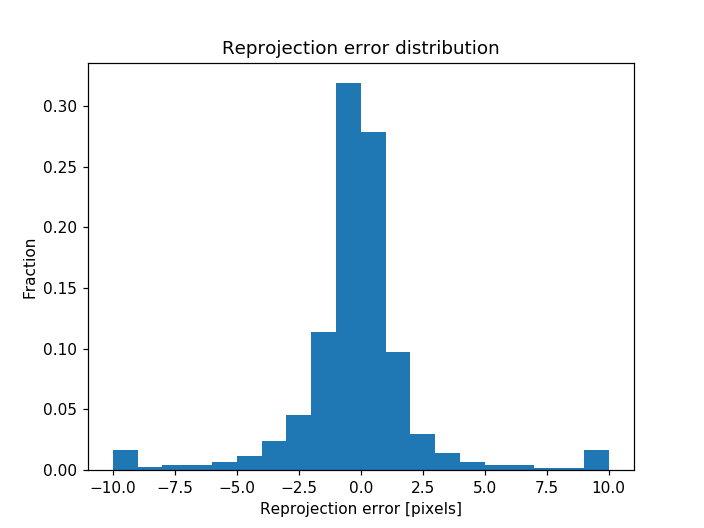

In [16]:
fig, ax = plt.subplots()
errors = sum((list(m.error(trajectory)) for m in image_measurements), [])
ax.hist(np.clip(errors, -10, 10), bins=20, normed=True)
_ = ax.set(title='Reprojection error distribution', xlabel='Reprojection error [pixels]', ylabel='Fraction')

We also plot a top view of the trajectory and the currently used landmarks.
Since the trajectory starts and ends at the exact same spot, we expect the curve to be closed.

<IPython.core.display.Javascript object>


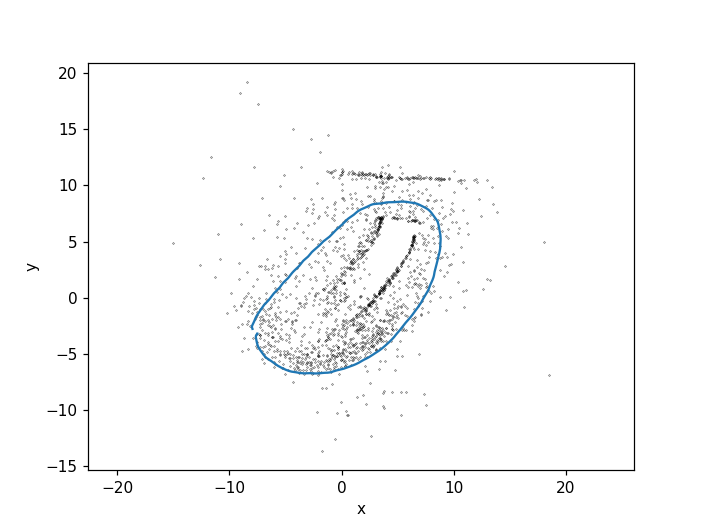

In [17]:
ex.plot_reconstruction(trajectory, selected_landmarks, camera)

### Compute landmark reprojection errors
We will use the mean reprojection error to select a new set of image measurements, and must therefore compute the reprojection errors of each landmark.

In [18]:
import collections
landmark_errors = collections.defaultdict(list)  # Landmark -> list of reprojection errors

For the landmarks that were used in the initial estimation we can simply extract the errors from the measurement list.

In [19]:
for m in image_measurements:
    lm = m.observation.landmark
    error = np.linalg.norm(m.error(trajectory))
    landmark_errors[lm].append(error)

For the other landmarks, we must triangulate the landmark given the trajectory, and then compute the resulting reprojection errors.
We do this by locking the trajectory and optimizing inverse depths for all landmarks visible in the keyframes.

In [20]:
keyframe_landmarks = {obs.landmark 
                      for v in keyframes
                      for obs in v.observations}

Since the trajectory should not be updated (only the inverse depths), we lock it.

In [21]:
trajectory.locked = True

Now run the triangulation for each landmark

In [22]:
for lm in keyframe_landmarks:
    if not lm in landmark_errors:
        # Measurements for the keyframes
        measurements = [StaticRsCameraMeasurement(camera, obs) 
                        for obs in lm.observations
                        if obs.view in keyframes]

        point_estimator = TrajectoryEstimator(trajectory)

        for m in measurements:
            point_estimator.add_measurement(m)

        point_estimator.solve(max_iterations=10, progress=False)
        
        for m in measurements:
            error = np.linalg.norm(m.error(trajectory))
            landmark_errors[lm].append(error)

Now unlock the trajectory to allow it to be updated again.

In [23]:
trajectory.locked = False

### Select new measurements

The new set of image measurements are chosen only from the landmarks with a reprojection error lower than 8 pixels.

In [24]:
max_error = 8.0
good_landmarks = {lm for lm, errors in landmark_errors.items() if np.mean(errors) < max_error}

We want to keep those landmarks that we already used, that were good enough.

In [25]:
preselected_landmarks = {m.observation.landmark for m in image_measurements if m.observation.landmark in good_landmarks}

Now select a new set of image measurements. The score used by ANMS is still the number of keyframes that the landmark spans.

In [26]:
selected_landmarks = set()

for v in keyframes:
    good_observations = [obs for obs in v.observations if obs.landmark in good_landmarks]
    scores = [landmark_keyframe_span[obs.landmark] for obs in good_observations]
    preselected = [obs for obs in good_observations if obs.landmark in preselected_landmarks]        
    chosen = ex.anms_sdc(good_observations, scores, num_obs_per_frame, (camera.rows, camera.cols), selected=preselected)
    selected_landmarks.update({obs.landmark for obs in chosen})

image_measurements = [
    StaticRsCameraMeasurement(camera, obs, huber_c) 
     for lm in selected_landmarks
     for obs in lm.observations
     if obs.view in keyframes and not obs.is_reference
]

In [27]:
print(f'Selected {len(image_measurements)} image measurements')

Selected 8050 image measurements


### Run a new estimation with the new measurements

In [28]:
estimator = TrajectoryEstimator(trajectory)

for m in imu_measurements:
    estimator.add_measurement(m)
    
for m in image_measurements:
    estimator.add_measurement(m)
    
result = estimator.solve(max_iterations=30)

print(result.BriefReport())

Ceres Solver Report: Iterations: 24, Initial cost: 9.008722e+04, Final cost: 8.380748e+04, Termination: CONVERGENCE


Plotting the distribution of reprojection errors, we can see that most outliers have now been removed.

<IPython.core.display.Javascript object>


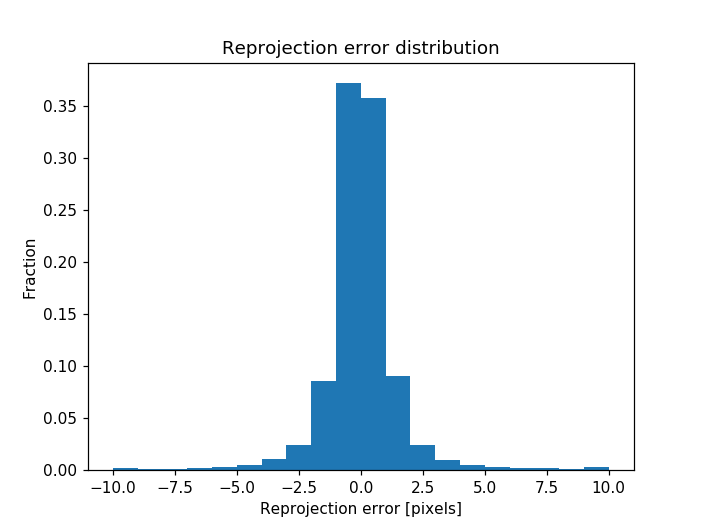

In [29]:
fig, ax = plt.subplots()
errors = sum((list(m.error(trajectory)) for m in image_measurements), [])
ax.hist(np.clip(errors, -10, 10), bins=20, normed=True)
_ = ax.set(title='Reprojection error distribution', xlabel='Reprojection error [pixels]', ylabel='Fraction')

... and the trajectory is almost closed, which is what we expect as the final goal.

<IPython.core.display.Javascript object>


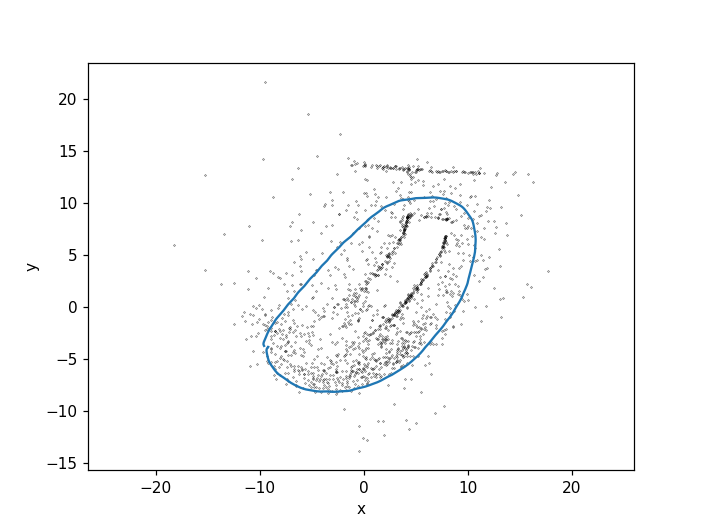

In [30]:
ex.plot_reconstruction(trajectory, selected_landmarks, camera)

### Run final bundle step with all views
Again we start by computing the mean reprojection error of the current measurements.

In [31]:
landmark_errors = collections.defaultdict(list)
for m in image_measurements:
    lm = m.observation.landmark
    error = np.linalg.norm(m.error(trajectory))
    landmark_errors[lm].append(error)

We now add *all observations*, for *all views*, for those currently used landmarks that have a reprojection error lower than 3 pixels.

In [32]:
max_error = 3.
good_landmarks = {lm for lm, errors in landmark_errors.items() if np.mean(errors) < max_error}

image_measurements = [
    StaticRsCameraMeasurement(camera, obs, huber_c)
    for lm in good_landmarks
    for obs in lm.observations
    if not obs.is_reference
]

In [33]:
print(f'Selected {len(image_measurements)} image measurements')

Selected 73998 image measurements


Now run the estimation.

In [34]:
estimator = TrajectoryEstimator(trajectory)

for m in imu_measurements:
    estimator.add_measurement(m)
    
for m in image_measurements:
    estimator.add_measurement(m)
    
result = estimator.solve(max_iterations=10)

print(result.BriefReport())

Ceres Solver Report: Iterations: 11, Initial cost: 3.170384e+05, Final cost: 1.638250e+05, Termination: NO_CONVERGENCE


A plot of the trajectory and 3D structure now shows a nice result, with a closed loop trajectory.

<IPython.core.display.Javascript object>


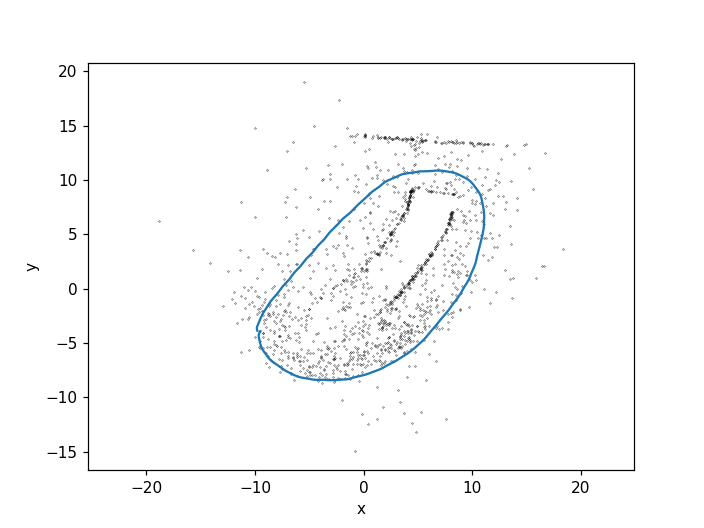

In [35]:
ex.plot_reconstruction(trajectory, good_landmarks, camera)

Finally, we can also verify that the final set of image measurements are virtually free of outliers, with normally distributed reprojection errors:

<IPython.core.display.Javascript object>


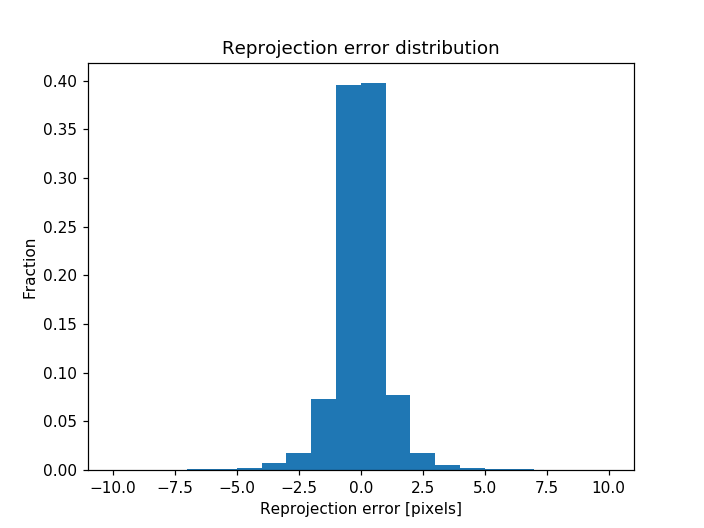

In [36]:
fig, ax = plt.subplots()
errors = sum((list(m.error(trajectory)) for m in image_measurements), [])
ax.hist(np.clip(errors, -10, 10), bins=20, normed=True)
_ = ax.set(title='Reprojection error distribution', xlabel='Reprojection error [pixels]', ylabel='Fraction')